In [24]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from scipy import stats
import scipy.cluster.hierarchy as hac

In [25]:
calendar_path = os.path.join(os.getcwd(), 'data', 'calendar.csv')
trainDF_path = os.path.join(os.getcwd(), 'data', 'sales_train_validation.csv')
pricesDF_path = os.path.join(os.getcwd(), 'data', 'sell_prices.csv')

df = pd.read_csv(trainDF_path)
calendarDF = pd.read_csv(calendar_path)
# pricesDF = pd.read_csv(pricesDF_path)

In [26]:
df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3


In [60]:
# normalize sales data 

from sklearn import preprocessing

colList = []

startDayNum = 1

for j in range((startDayNum-1),int(df.iloc[:,6:].shape[1])):
    colName = 'd_' + str(j+1)
    colList.append(colName)

x = df.iloc[:,(5+startDayNum):].values #converts to numpy array
# x = df.iloc[:,1183:].values # ONLY MOST RECENT 2 YEARS

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x.transpose())

dfNorm = pd.DataFrame(x_scaled.transpose(), columns=colList)

# drop any rows with no sales
dfNorm = dfNorm.loc[(dfNorm!=0).any(axis=1)]

# convert to np
npNorm = np.array(dfNorm)


# uncomment for moving average
window = 35
dfNorm = dfNorm.transpose().rolling(window=window).mean().transpose().iloc[:,window:]
npNorm = np.array(dfNorm.iloc[:,window:])

dfNorm




,d_36,d_37,d_38,d_39,d_40,d_41,d_42,d_43,d_44,d_45,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.194286,0.211429,0.211429,0.217143,0.217143,0.217143,0.228571,0.211429,0.211429,0.200000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.034286,0.028571,0.028571,0.028571,0.028571,0.034286,0.034286,0.034286,0.034286,0.034286
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.057143,0.057143,0.061905,0.066667,0.071429,0.076190,0.076190,0.076190,0.080952,0.085714
3,0.000000,0.003810,0.003810,0.003810,0.003810,0.007619,0.007619,0.009524,0.009524,0.009524,...,0.133333,0.131429,0.137143,0.139048,0.140952,0.139048,0.135238,0.133333,0.142857,0.144762
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.136508,0.136508,0.136508,0.130159,0.130159,0.130159,0.136508,0.133333,0.133333,0.139683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,0.276190,0.292857,0.302381,0.307143,0.321429,0.321429,0.333333,0.328571,0.333333,0.342857,...,0.009524,0.009524,0.009524,0.009524,0.009524,0.009524,0.011905,0.011905,0.011905,0.014286
30486,0.090476,0.097619,0.107143,0.116667,0.123810,0.126190,0.128571,0.126190,0.126190,0.123810,...,0.019048,0.019048,0.019048,0.019048,0.019048,0.019048,0.019048,0.019048,0.021429,0.021429
30487,0.218571,0.221429,0.222857,0.228571,0.230000,0.228571,0.232857,0.235714,0.234286,0.240000,...,0.048571,0.048571,0.047143,0.050000,0.045714,0.045714,0.044286,0.041429,0.042857,0.042857
30488,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.095238,0.092857,0.088095,0.088095,0.080952,0.080952,0.078571,0.083333,0.083333,0.088095


No handles with labels found to put in legend.


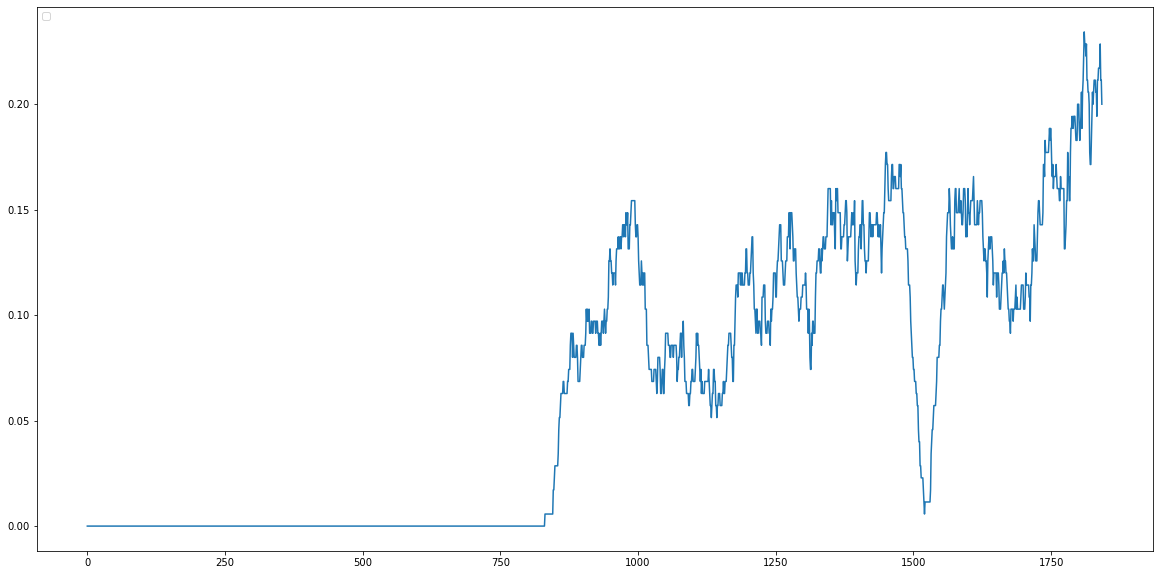

In [61]:
itemNum = 0
sales1 = npNorm[itemNum]
# sales1 = df.iloc[itemNum,1250:]

# label1 = [df.iloc[itemNum,0]]

plt.figure(figsize=(20,10))
plt.plot(sales1)
plt.legend(loc='upper left')
plt.show()

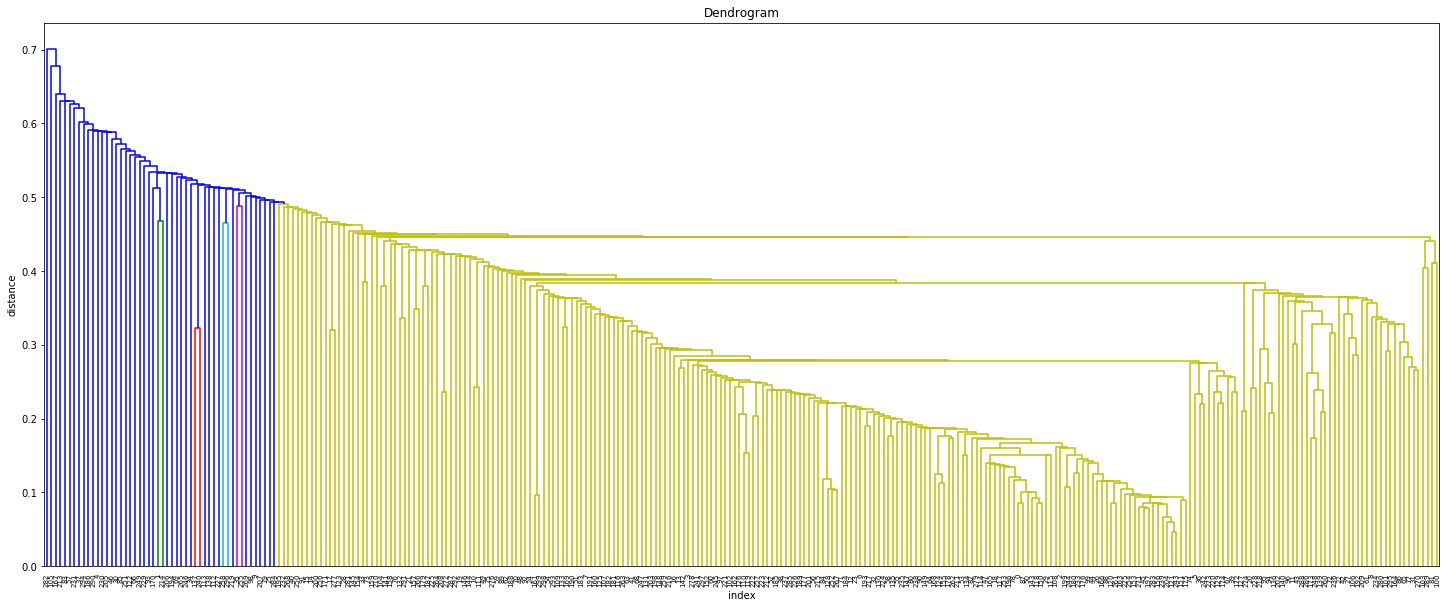

In [62]:
Z = hac.linkage(npNorm[:300], method='single', metric='correlation')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
hac.dendrogram(Z, leaf_rotation=90, leaf_font_size=7)

plt.show()

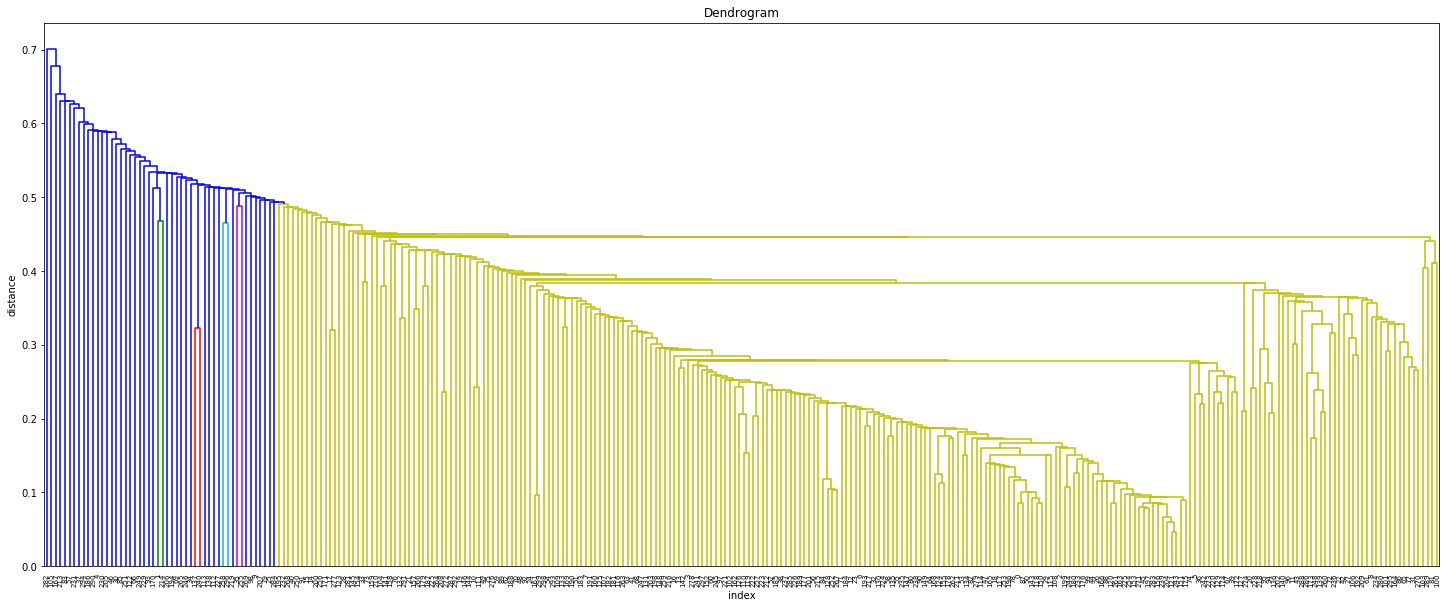

In [63]:
# spearman correlation
def spearmancorr(x, y):
    r = stats.pearsonr(x, y)[0]
    return(1 - r) # correlation to distance: range 0 to 2

# clustering    
Z = hac.linkage(npNorm[:300],  method='single', metric=spearmancorr)

# dendogram
plt.figure(figsize=(25, 10))
plt.title('Dendrogram')
plt.xlabel('index')
plt.ylabel('distance')
hac.dendrogram(Z, leaf_rotation=90, leaf_font_size=7)

plt.show()

In [64]:
from scipy.cluster.hierarchy import fcluster

def print_clusters(npNorm, Z, k):
    # k Number of clusters to extract
    results = fcluster(Z, k, criterion='maxclust')

    # check the results
    s = pd.Series(results)
    clusters = s.unique()

    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))

numClusters = 6
print_clusters(npNorm, Z, 6)



Cluster 1 number of entries 295
Cluster 2 number of entries 1
Cluster 5 number of entries 1
Cluster 4 number of entries 1
Cluster 3 number of entries 1
Cluster 6 number of entries 1


In [32]:
# get clusters

numClusters = 6

clusterList = fcluster(Z, numClusters, criterion='maxclust')

print(clusterList)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1
 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [33]:
asdf = pd.DataFrame(clusterList, columns=['cluster'])
asdf.index[asdf['cluster']==6]

Int64Index([75], dtype='int64')

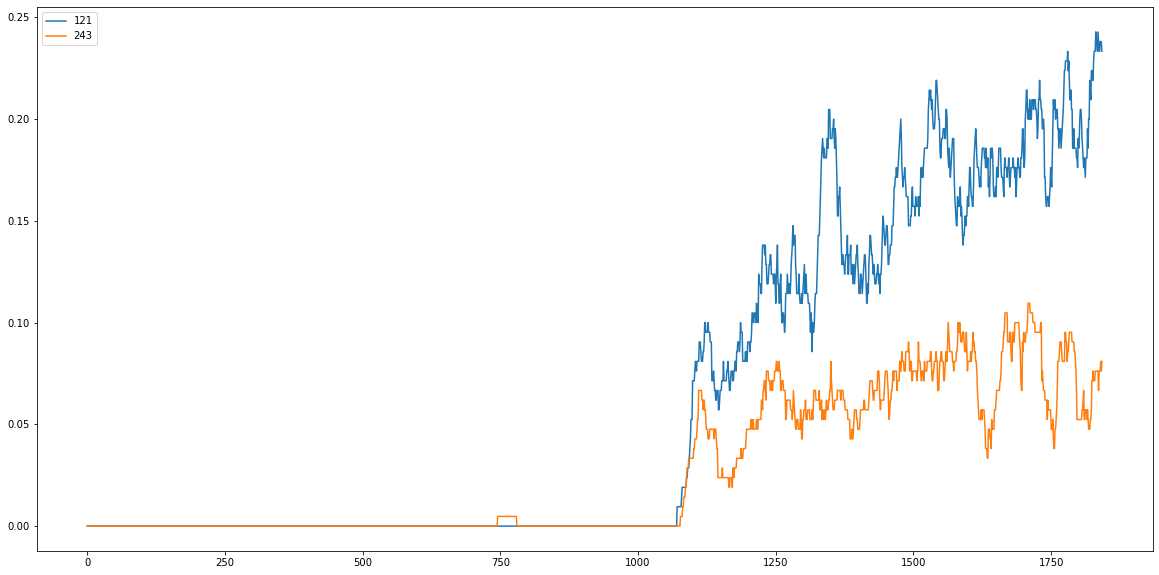

In [65]:

plt.figure(figsize=(20,10))
plt.plot(npNorm[121], label='121')
plt.plot(npNorm[243], label='243')
plt.legend(loc='upper left')
plt.show()